### __NLP Disaster Tweets: Simple Bidirectional LSTM Based on RNN:__ 

> - https://www.kaggle.com/code/maunilshah/real-or-not-a-simple-bidirectional-rnn
> - https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
> - https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
> - https://www.kaggle.com/code/xhlulu/disaster-nlp-keras-bert-using-tfhub
> - https://www.kaggle.com/competitions/nlp-getting-started/discussion/298861


Other Reference Links:
> - https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers
> - for EDA: https://www.kaggle.com/code/dnyaneshwalwadkar/84-disaster-prediction-with-adv-nlp-adv-eda
> - https://www.pluralsight.com/guides/data-visualization-deep-learning-model-using-matplotlib

In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, re, random, math
import string
import time
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from bs4 import BeautifulSoup
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

# to be able to see multiple ouputs from sungle cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### __Function Set-Up & Notes__
> - seed set up to get the same output
> - will try both, unpreprocessed and fully preprocessed data

In [52]:
def seed_everything(SEED = 13):
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    os.environ['PYTHONHASHSEED'] = str(SEED)
    
seed_everything()
print('seeded everything to get same output')

seeded everything to get same output


#### __Import Data__

In [53]:
# import train data
test_df = pd.read_csv('/content/test.csv')
test_df.info()
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [54]:
# import train data
train_df = pd.read_csv('/content/train.csv')
train_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [55]:
# import preprocessed test data
test_processed_df = pd.read_csv('/content/preprocessed2nd_test_data.csv')
test_processed_df.info()
test_processed_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     3263 non-null   int64 
 1   keyword                3263 non-null   object
 2   location               3263 non-null   object
 3   text                   3263 non-null   object
 4   text_preprocessed      3263 non-null   object
 5   text_preprocessed_2nd  3263 non-null   object
dtypes: int64(1), object(5)
memory usage: 153.1+ KB


,id,keyword,location,text,text_preprocessed,text_preprocessed_2nd
0,0,None,None,Just happened a terrible car crash,happened terrible car crash,happened terrible car crash
1,2,None,None,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,heard earthquake different city stay safe ever...
2,3,None,None,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...,forest fire spot pond goose fleeing across str...
3,9,None,None,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,apocalypse lighting spokane wildfire
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...,...,...
3258,10861,None,None,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fastener ...,earthquake safety los angeles safety fastener ...
3259,10865,None,None,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city others hard...,storm ri worse last hurricane city others hard...
3260,10868,None,None,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago,green line derailment chicago
3261,10874,None,None,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issue hazardous weather outlook hwo,meg issue hazardous weather outlook hwo


In [56]:
# import preprocessed train data
train_processed_df = pd.read_csv('/content/preprocessed2nd_train_data.csv')
train_processed_df.info()
train_processed_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7503 entries, 0 to 7502
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     7503 non-null   int64 
 1   keyword                7503 non-null   object
 2   location               7503 non-null   object
 3   text                   7503 non-null   object
 4   target                 7503 non-null   int64 
 5   text_preprocessed      7503 non-null   object
 6   text_preprocessed_2nd  7503 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.4+ KB


,id,keyword,location,text,target,text_preprocessed,text_preprocessed_2nd
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive you,deed reason earthquake may allah forgive you
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...,resident asked shelter place notified officer ...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,people receive wildfire evacuation order calif...
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...
7498,10863,None,None,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnews fallen powerlines g link tram update...,worldnews fallen powerlines g link tram update...
7499,10864,None,None,on the flip side I'm at Walmart and there is a...,1,flip side walmart bomb everyone evacuate stay ...,flip side walmart bomb everyone evacuate stay ...
7500,10866,None,None,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kill saudi security site mosque...,suicide bomber kill saudi security site mosque...
7501,10869,None,None,Two giant cranes holding a bridge collapse int...,1,two giant crane holding bridge collapse nearby...,two giant crane holding bridge collapse nearby...


#### __Data Preparation__

In [57]:
# start time to measure the time of the program execution
start_time = time.time()

p_train_df = train_df.drop(['id', 'keyword', 'location'],axis=1)
p_train_processed_df = train_processed_df.drop(['id', 'keyword', 'location', 
                                          'text', 'text_preprocessed'],axis=1)

# check
print(f"\np_train_df: {p_train_df.shape}")
print(f"\np_train_processed_df: {p_train_processed_df.shape}")

p_train_df
p_train_processed_df

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")


p_train_df: (7613, 2)

p_train_processed_df: (7503, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


,target,text_preprocessed_2nd
0,1,deed reason earthquake may allah forgive you
1,1,forest fire near la ronge sask canada
2,1,resident asked shelter place notified officer ...
3,1,people receive wildfire evacuation order calif...
4,1,got sent photo ruby alaska smoke wildfire pour...
...,...,...
7498,1,worldnews fallen powerlines g link tram update...
7499,1,flip side walmart bomb everyone evacuate stay ...
7500,1,suicide bomber kill saudi security site mosque...
7501,1,two giant crane holding bridge collapse nearby...




--- 0.01752614974975586 seconds ---


#### __Function for Constructing Layers for RNN__

In [58]:
def myModel():    
  model = Sequential(name='Bidirectional_RNN')
  model.add(Embedding(1000, 256, input_length = 256))

  model.add(Bidirectional(LSTM(128, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
  model.add(Dropout(0.5))
    
  model.add(Bidirectional(LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
  model.add(Dropout(0.5))
    
  model.add(Bidirectional(LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
  model.add(Dropout(0.4))
    
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.1))
    
  model.add(Dense(1, activation = 'sigmoid'))

  print(model.summary())

  return model


In [59]:
# start time to measure the time of the program execution
start_time = time.time()

%time
model = myModel()    
model.compile(
optimizer=Adam(learning_rate=0.0001),
loss='binary_crossentropy',
metrics=['Accuracy']
)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 28.6 µs
Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 256, 256)          256000    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         394240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 128)         164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256, 128)          0         
                                                 

### __(a) Model Performance on Unpreprocessed Train Data__

In [62]:
# start time to measure the time of the program execution
start_time = time.time()

text = p_train_df['text']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text.values)

x_train = tokenizer.texts_to_sequences(text.values)
x_train = pad_sequences(x_train, maxlen=256)

print('generated pad sequences')

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

generated pad sequences


--- 0.33699822425842285 seconds ---


In [63]:
# start time to measure the time of the program execution
start_time = time.time()

y_train = p_train_df['target']
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

chk_point = ModelCheckpoint(
    '/content/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

es = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs = 100,
    callbacks=[es,lr,chk_point],
    shuffle=True,
    verbose=1
)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

Epoch 1/100
96/96 [==============================] - 58s 608ms/step - loss: 3.2765 - Accuracy: 0.8251 - val_loss: 2.9015 - val_Accuracy: 0.7919 - lr: 1.0000e-04
Epoch 2/100
96/96 [==============================] - 58s 606ms/step - loss: 2.5388 - Accuracy: 0.8346 - val_loss: 2.2708 - val_Accuracy: 0.7978 - lr: 1.0000e-04
Epoch 3/100
96/96 [==============================] - 58s 607ms/step - loss: 1.9828 - Accuracy: 0.8424 - val_loss: 1.8044 - val_Accuracy: 0.8050 - lr: 1.0000e-04
Epoch 4/100
96/96 [==============================] - 58s 606ms/step - loss: 1.5726 - Accuracy: 0.8478 - val_loss: 1.4643 - val_Accuracy: 0.8004 - lr: 1.0000e-04
Epoch 5/100
96/96 [==============================] - 58s 607ms/step - loss: 1.3134 - Accuracy: 0.8218 - val_loss: 1.2509 - val_Accuracy: 0.7781 - lr: 1.0000e-04
Epoch 6/100
96/96 [==============================] - 58s 608ms/step - loss: 1.0767 - Accuracy: 0.8366 - val_loss: 1.0445 - val_Accuracy: 0.7978 - lr: 1.0000e-04
Epoch 7/100
96/96 [===============

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epochs')

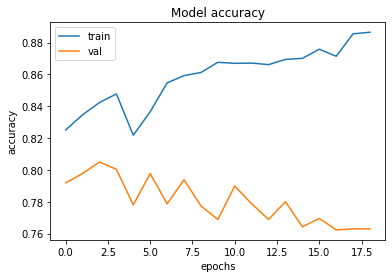

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epochs')

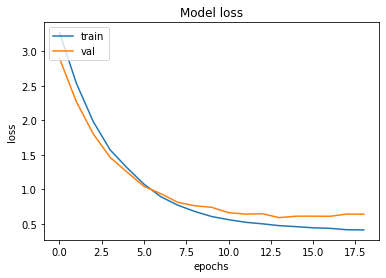



--- 0.3236374855041504 seconds ---


In [64]:
# Visualize scores - with unpreprocessed train data

# start time to measure the time of the program execution
start_time = time.time()

# accuracy score
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss calculation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

#### __Prediction & Submission Prep for Unpreprocessed Test Data__

In [65]:
# start time to measure the time of the program execution
start_time = time.time()

# Prep Test Data for RNN/LSTM
test_df.head()

text = test_df['text']
x_test = tokenizer.texts_to_sequences(text.values)
x_test = pad_sequences(x_test, maxlen=256)

print('generated pad sequences')

# Prediction
model = load_model('/content/best_model.h5')
preds = model.predict(x_test)
pred = [1 if i>0.5 else 0 for i in preds]

# Submission File
submission=pd.DataFrame()
submission['id']=test_df['id'].to_list()
submission['target']=pred

submission.to_csv('trial16_submission_noclean_rnn_lstm.csv',index=False)
submission.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


generated pad sequences


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1




--- 13.798547267913818 seconds ---


### __(b) Model Performance on Preprocessed Train Data__

In [66]:
2# start time to measure the time of the program execution
start_time = time.time()

text2 = p_train_processed_df['text_preprocessed_2nd']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(text2.values)

x_train2 = tokenizer.texts_to_sequences(text2.values)
x_train2 = pad_sequences(x_train2, maxlen=256)

print('generated pad sequences')

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

generated pad sequences


--- 0.20836114883422852 seconds ---


In [67]:
# start time to measure the time of the program execution
start_time = time.time()

y_train2 = p_train_processed_df['target']
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    verbose=0,
    mode='min'
)

chk_point = ModelCheckpoint(
    '/content/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

es = EarlyStopping(
    patience=5,
    min_delta=0,
    monitor='val_loss',
    verbose=0,
    mode='min',
    baseline=None
)

history2 = model.fit(
    x_train2, y_train2,
    validation_split=0.2,
    batch_size=64,
    epochs = 100,
    callbacks=[es,lr,chk_point],
    shuffle=True,
    verbose=1
)

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

Epoch 1/100
94/94 [==============================] - 66s 639ms/step - loss: 0.8004 - Accuracy: 0.5818 - val_loss: 0.7847 - val_Accuracy: 0.5590 - lr: 1.0000e-04
Epoch 2/100
94/94 [==============================] - 57s 608ms/step - loss: 0.7616 - Accuracy: 0.5980 - val_loss: 0.7703 - val_Accuracy: 0.5643 - lr: 1.0000e-04
Epoch 3/100
94/94 [==============================] - 57s 609ms/step - loss: 0.7466 - Accuracy: 0.6080 - val_loss: 0.7528 - val_Accuracy: 0.5803 - lr: 1.0000e-04
Epoch 4/100
94/94 [==============================] - 57s 609ms/step - loss: 0.7249 - Accuracy: 0.6311 - val_loss: 0.7324 - val_Accuracy: 0.6049 - lr: 1.0000e-04
Epoch 5/100
94/94 [==============================] - 57s 610ms/step - loss: 0.6795 - Accuracy: 0.6791 - val_loss: 0.6531 - val_Accuracy: 0.6902 - lr: 1.0000e-04
Epoch 6/100
94/94 [==============================] - 57s 607ms/step - loss: 0.5513 - Accuracy: 0.7876 - val_loss: 0.5719 - val_Accuracy: 0.7588 - lr: 1.0000e-04
Epoch 7/100
94/94 [===============

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epochs')

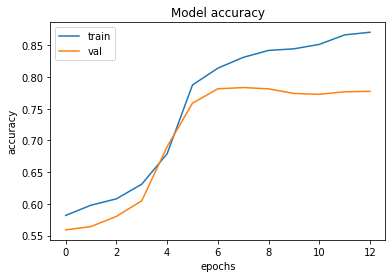

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epochs')

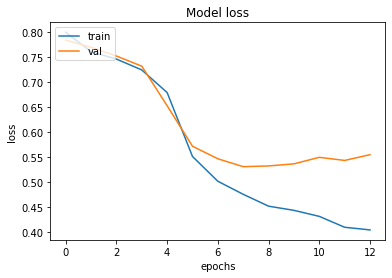



--- 0.3053250312805176 seconds ---


In [69]:
# Visualize scores - with preprocessed train data

# start time to measure the time of the program execution
start_time = time.time()

# accuracy score
plt.plot(history2.history['Accuracy'])
plt.plot(history2.history['val_Accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss calculation
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

#### __Prediction & Submission Prep for Preprocessed Test Data__

In [70]:
# start time to measure the time of the program execution
start_time = time.time()

# Prep Test Data for RNN/LSTM
test_processed_df.head()

text2 = test_processed_df['text_preprocessed_2nd']
x_test2 = tokenizer.texts_to_sequences(text2.values)
x_test2 = pad_sequences(x_test2, maxlen=256)

print('generated pad sequences')

# Prediction
model = load_model('/content/best_model.h5')
preds2 = model.predict(x_test2)
pred2 = [1 if i>0.5 else 0 for i in preds2]

# Submission File
submission=pd.DataFrame()
submission['id']=test_processed_df['id'].to_list()
submission['target']=pred2

submission.to_csv('trial17_submission_clean_rnn_lstm.csv',index=False)
submission.head()

# print the overall program runtime.
print(f"\n\n--- {(time.time() - start_time)} seconds ---")

,id,keyword,location,text,text_preprocessed,text_preprocessed_2nd
0,0,None,None,Just happened a terrible car crash,happened terrible car crash,happened terrible car crash
1,2,None,None,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...,heard earthquake different city stay safe ever...
2,3,None,None,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...,forest fire spot pond goose fleeing across str...
3,9,None,None,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire,apocalypse lighting spokane wildfire
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,typhoon soudelor kill china taiwan


generated pad sequences


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1




--- 14.053177118301392 seconds ---
